In [9]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# my own module
from conf.configure import Configure
from utils import data_util

In [10]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import time
#%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LassoCV,LassoLarsCV, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from time import time

R2 = make_scorer(r2_score, greater_is_better=True)

In [11]:
print 'load datas...'
train, test = data_util.load_dataset()

y_train_all = train['y']
del train['ID']
del train['y']
id_test = test['ID']
del test['ID']

load datas...


In [12]:
X_train = train
X_test = test
y_train = y_train_all
y_mean = np.mean(y_train)
del train, test, y_train_all

In [13]:
X_train.shape, X_test.shape

((4209, 580), (4209, 580))

In [14]:
def DeepCV(train, y_train_all, model): 
    train_r2_scores = []
    val_r2_scores = []
    num_boost_roundses = []
    df_columns = train.columns.values
    for i in range(0, 5):
        random_state = 42 + i
        X_train, X_val, y_train, y_val = train_test_split(train, y_train_all, test_size=0.25, random_state=random_state)

        y_mean = np.mean(y_train)
        model.fit(X_train, y_train)
        train_r2_score = r2_score(y_train, model.predict(X_train))
        val_r2_score = r2_score(y_val, model.predict(X_val))
        print 'perform {} cross-validate: train r2 score = {}, validate r2 score = {}'.format(i + 1, train_r2_score,
                                                                                              val_r2_score)
        train_r2_scores.append(train_r2_score)
        val_r2_scores.append(val_r2_score)

    print '\naverage train r2 score = {}, average validate r2 score = {}'.format(
        sum(train_r2_scores) / len(train_r2_scores),
        sum(val_r2_scores) / len(val_r2_scores))
    
def PrintImportance(X_train, y_train, model):
    model.fit(X_train, y_train)
    feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)[:50]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.figure(figsize=(50,50))

In [15]:
gbm0 = GradientBoostingRegressor(random_state=10)
DeepCV(X_train, y_train, gbm0)


perform 1 cross-validate: train r2 score = 0.733302603861, validate r2 score = 0.519523745861
perform 2 cross-validate: train r2 score = 0.725647607906, validate r2 score = 0.561407101079
perform 3 cross-validate: train r2 score = 0.74309298247, validate r2 score = 0.525925705237
perform 4 cross-validate: train r2 score = 0.725281053699, validate r2 score = 0.590909096506
perform 5 cross-validate: train r2 score = 0.725509225205, validate r2 score = 0.485169840901

average train r2 score = 0.730566694628, average validate r2 score = 0.536587097917


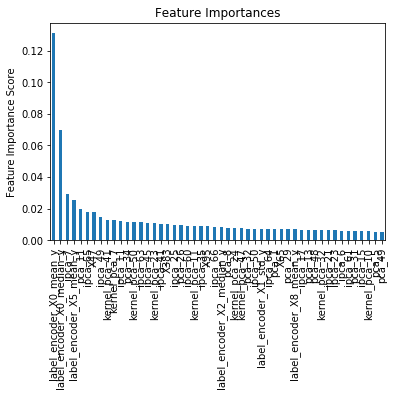

In [16]:
PrintImportance(X_train, y_train, gbm0)

In [19]:
param_test = {'n_estimators':range(20,81,10)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,
                        min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=R2, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.54284, std: 0.08617, params: {'n_estimators': 20},
  mean: 0.55935, std: 0.08891, params: {'n_estimators': 30},
  mean: 0.56469, std: 0.09055, params: {'n_estimators': 40},
  mean: 0.56449, std: 0.09215, params: {'n_estimators': 50},
  mean: 0.56431, std: 0.09330, params: {'n_estimators': 60},
  mean: 0.56400, std: 0.09326, params: {'n_estimators': 70},
  mean: 0.56290, std: 0.09312, params: {'n_estimators': 80}],
 {'n_estimators': 40},
 0.5646896377259061)

In [23]:
param_test = {'max_depth':range(5,16,2), 'min_samples_split':range(20,100,20)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=40,
                        min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=R2, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.56504, std: 0.09034, params: {'min_samples_split': 20, 'max_depth': 5},
  mean: 0.56504, std: 0.09034, params: {'min_samples_split': 40, 'max_depth': 5},
  mean: 0.56504, std: 0.09034, params: {'min_samples_split': 60, 'max_depth': 5},
  mean: 0.56504, std: 0.09034, params: {'min_samples_split': 80, 'max_depth': 5},
  mean: 0.56140, std: 0.08849, params: {'min_samples_split': 20, 'max_depth': 7},
  mean: 0.56140, std: 0.08849, params: {'min_samples_split': 40, 'max_depth': 7},
  mean: 0.56140, std: 0.08849, params: {'min_samples_split': 60, 'max_depth': 7},
  mean: 0.56140, std: 0.08849, params: {'min_samples_split': 80, 'max_depth': 7},
  mean: 0.55761, std: 0.08404, params: {'min_samples_split': 20, 'max_depth': 9},
  mean: 0.55761, std: 0.08404, params: {'min_samples_split': 40, 'max_depth': 9},
  mean: 0.55761, std: 0.08404, params: {'min_samples_split': 60, 'max_depth': 9},
  mean: 0.55761, std: 0.08404, params: {'min_samples_split': 80, 'max_depth': 9},
  mean: 0.55761,

In [24]:
param_test = {'max_depth':range(4,7,1), 'min_samples_leaf':range(30,71,10)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=40,
                        min_samples_split=20,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=R2, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.56291, std: 0.08823, params: {'max_depth': 4, 'min_samples_leaf': 30},
  mean: 0.56291, std: 0.08782, params: {'max_depth': 4, 'min_samples_leaf': 40},
  mean: 0.56406, std: 0.09228, params: {'max_depth': 4, 'min_samples_leaf': 50},
  mean: 0.56369, std: 0.08903, params: {'max_depth': 4, 'min_samples_leaf': 60},
  mean: 0.56303, std: 0.08731, params: {'max_depth': 4, 'min_samples_leaf': 70},
  mean: 0.56564, std: 0.08651, params: {'max_depth': 5, 'min_samples_leaf': 30},
  mean: 0.56328, std: 0.08819, params: {'max_depth': 5, 'min_samples_leaf': 40},
  mean: 0.56504, std: 0.09034, params: {'max_depth': 5, 'min_samples_leaf': 50},
  mean: 0.56706, std: 0.08847, params: {'max_depth': 5, 'min_samples_leaf': 60},
  mean: 0.56376, std: 0.08946, params: {'max_depth': 5, 'min_samples_leaf': 70},
  mean: 0.56387, std: 0.08909, params: {'max_depth': 6, 'min_samples_leaf': 30},
  mean: 0.56575, std: 0.09324, params: {'max_depth': 6, 'min_samples_leaf': 40},
  mean: 0.56011, std: 0.0888

In [25]:
param_test = {'n_estimators':range(20,81,10)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20,
                        min_samples_leaf=60,max_depth=5, max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test, scoring=R2, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.54357, std: 0.08623, params: {'n_estimators': 20},
  mean: 0.56071, std: 0.08841, params: {'n_estimators': 30},
  mean: 0.56706, std: 0.08847, params: {'n_estimators': 40},
  mean: 0.56819, std: 0.09070, params: {'n_estimators': 50},
  mean: 0.56805, std: 0.09147, params: {'n_estimators': 60},
  mean: 0.56694, std: 0.09292, params: {'n_estimators': 70},
  mean: 0.56679, std: 0.09394, params: {'n_estimators': 80}],
 {'n_estimators': 50},
 0.5681880676609476)

In [28]:
param_test = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50,min_samples_leaf=60,
                        min_samples_split=20,max_features='sqrt',max_depth=5,random_state=10), 
param_grid = param_test, scoring=R2, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.56426, std: 0.09095, params: {'subsample': 0.6},
  mean: 0.55953, std: 0.08847, params: {'subsample': 0.7},
  mean: 0.56776, std: 0.08894, params: {'subsample': 0.75},
  mean: 0.56819, std: 0.09070, params: {'subsample': 0.8},
  mean: 0.56260, std: 0.09131, params: {'subsample': 0.85},
  mean: 0.56333, std: 0.09211, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.5681880676609476)

In [29]:
param_test = {'max_features':1/10.0*np.arange(1,10,1)}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50,min_samples_leaf=60,
                        min_samples_split=20,subsample=0.8,max_depth=5,random_state=10), 
param_grid = param_test, scoring=R2, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.56844, std: 0.09378, params: {'max_features': 0.10000000000000001},
  mean: 0.56797, std: 0.08902, params: {'max_features': 0.20000000000000001},
  mean: 0.56760, std: 0.09144, params: {'max_features': 0.30000000000000004},
  mean: 0.57172, std: 0.09258, params: {'max_features': 0.40000000000000002},
  mean: 0.56917, std: 0.09169, params: {'max_features': 0.5},
  mean: 0.56907, std: 0.09085, params: {'max_features': 0.60000000000000009},
  mean: 0.56884, std: 0.09252, params: {'max_features': 0.70000000000000007},
  mean: 0.56764, std: 0.09407, params: {'max_features': 0.80000000000000004},
  mean: 0.56713, std: 0.09351, params: {'max_features': 0.90000000000000002}],
 {'max_features': 0.40000000000000002},
 0.5717186214836556)

In [30]:
DeepCV(model=gsearch, train=X_train, y_train_all=y_train)

perform 1 cross-validate: train r2 score = 0.651479288942, validate r2 score = 0.559670742634
perform 2 cross-validate: train r2 score = 0.665232368721, validate r2 score = 0.557367922229
perform 3 cross-validate: train r2 score = 0.676688846903, validate r2 score = 0.528358040512
perform 4 cross-validate: train r2 score = 0.651576771735, validate r2 score = 0.598332433492
perform 5 cross-validate: train r2 score = 0.685262777142, validate r2 score = 0.477756182351

average train r2 score = 0.666048010689, average validate r2 score = 0.544297064244


In [31]:
param_test = {'learning_rate':[.1,.05,.02,.01]}
gsearch = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50,
                        min_samples_leaf=60, min_samples_split=20,subsample=0.8, max_features=.4,
                        max_depth=5,random_state=10), 
param_grid = param_test, scoring=R2, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train,y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: 0.57172, std: 0.09258, params: {'learning_rate': 0.1},
  mean: 0.57217, std: 0.08726, params: {'learning_rate': 0.05},
  mean: 0.49940, std: 0.07609, params: {'learning_rate': 0.02},
  mean: 0.36316, std: 0.05652, params: {'learning_rate': 0.01}],
 {'learning_rate': 0.05},
 0.5721697269773811)

In [33]:
DeepCV(X_train, y_train, gsearch)

perform 1 cross-validate: train r2 score = 0.619457970391, validate r2 score = 0.569788367525
perform 2 cross-validate: train r2 score = 0.621361063819, validate r2 score = 0.567622972506
perform 3 cross-validate: train r2 score = 0.634330377805, validate r2 score = 0.539410778954
perform 4 cross-validate: train r2 score = 0.614734115646, validate r2 score = 0.604223008723
perform 5 cross-validate: train r2 score = 0.659921562445, validate r2 score = 0.475552209341

average train r2 score = 0.629961018021, average validate r2 score = 0.55131946741


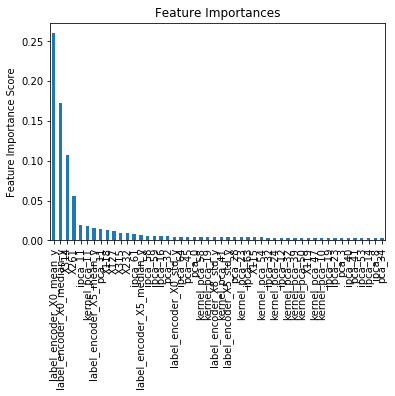

In [34]:
model=GradientBoostingRegressor(learning_rate=0.05, n_estimators=50,
                        min_samples_leaf=60, min_samples_split=20,subsample=0.8, max_features=.4,
                        max_depth=5,random_state=10)
PrintImportance(model=model, X_train=X_train, y_train=y_train)

In [35]:
GBMreg=GradientBoostingRegressor(learning_rate=0.05, n_estimators=50,min_samples_leaf=60,
                        min_samples_split=20, max_features=.4, max_depth=5,
                                 subsample=0.8,random_state=10)
GBMreg.fit(X_train, y_train)
y_predict = GBMreg.predict(X_test)

#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
#output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})

In [36]:
output = pd.DataFrame({'ID': id_test, 'y': y_predict})
output.to_csv('../result/jul3_1.csv', index=False)